# Operating System Definition ?

### What an Operating System is Depends on the Application

Android and Debian both use the Linux kernel, but the applications are different  
(but you can say that they're the same OS, if you only use their terminal applications) (you can run C code on Android!)

"Linux" distributions may be considered GNU/Linux  
GNU distributes the standard C library and common utilities

<mark>An operating system consists of a kernel and libraries required for your application</mark>

Applications may pass through Multiple Layers of Libraries

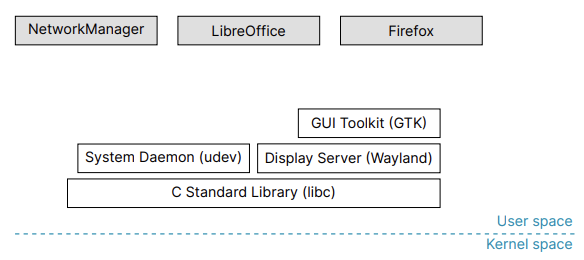

# Libraries

Recall: Normal compilation in C:

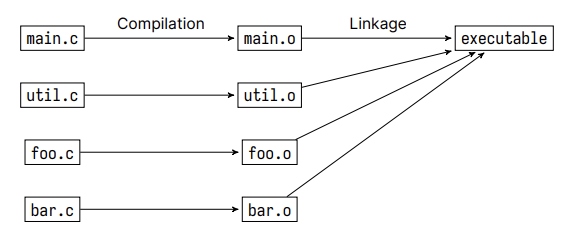

### 1. Static Libraries

Static Libraries are included at <mark>Link Time</mark> (will have .a in Linux)

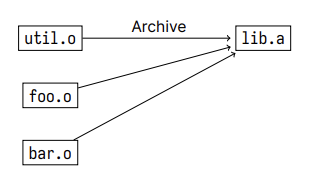 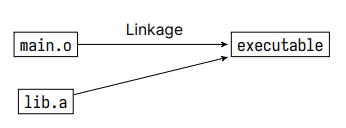

### 2. Dynamic Libraries

Dynamic Libraries are for reusable code (.so in Linux, .dll in Windows)

Basically also a collection of .o files containing function definitions, but they are <mark>NOT included in the executable</mark>  
Dynamic Libraries are **loaded by the OS only ONCE, and shares it between applications**  

*The C standard library libc.so is a dynamic library*

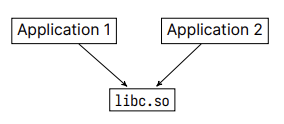

<mark>**Dynamic libraries are included at RUNTIME**</mark>

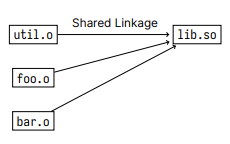 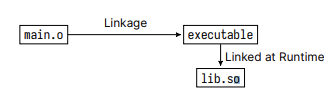

### Static vs Dynamic libraries

1. The drawbacks of static libraries:
- Statically linking **prevents re-using** libraries (you'll copy and paste the static libraries into the executable)  
--> Any updates to a static library requires the executable to be **recompiled**

2. Drawbacks of dynamic libraries:
- Dynamic Libraries updates can break executables, by changing ABI and causing a crash in applications that uses it (see example)


#### Creating and using Dynamic Libraries

- To create, we make a header file (point.h) for function declarations. Define the functions in point.c. Then, compile point.c (to point.o) and make a library (point.so)
- To use, you still need to #include <dynamic_library_header_file.h> if you want to use the DLL. At runtime, the function declarations of the library will be found and executed.


### Example:

C Uses a Consistent ABI for structs, meaning: 

- structs are laid out in memory with the fields matching the declaration order

Consider the following structures:

    // Library v1:
    struct point {      // translate to int array[2]
        int y;          // y -> array[0]
        int x;          // x -> array[1]
    };

    // Library v2:
    struct point {
        int x;          // x -> array[0]
        int y;          // y -> array[1]
    };

- Now assume the Library API has 4 functions:

![Alt text](images/image-1.png)
*Note: these are API calls*

In [1]:
%%file run.c

// This is our program

#include <stdio.h>
#include <stdlib.h>
#include "point.h"
int main(void) {
    struct point *p = point_create(1, 2);
    
    printf("point (x, y) = %d, %d (using library)\n", point_get_x(p), point_get_y(p));
    
    printf("point (x, y) = %d, %d (using struct)\n", p->x, p->y);
    
    point_destroy(p);
    return 0;
}

Overwriting run.c


1. If compiled with library v1, linked with library v1 or (v2 -> v2), results will be same
2. If compiled with library v1, linked with library v2 or (v2 -> v1), there **IS A MISMATCH**

#### Why?

- Using library calls will give the same result (because these calls are done at runtime, by the linked library)
- Using direct, exposed struct access will give the opposite result. (Example: compile with v1, link with v2):
    - point_create(1,2) is executed **at runtime**, which correctly creates x = 1, y = 2 (API of point_create) and doesn't matter which library
    - point_get_x is executed **at runtime**, which is v2 (also API). And so point_get_x(p) internally will possibly do p->x, but it's v2's point
    - Now for direct access: v1 compiled executables will generate instructions to access x (array[1] of v1 point), then y (array[0] of v1 point)
    - But when linked with v2, these instructions will mean accessing y (array[1] of v2 point), then x (array[0] of v2 point)

![Alt text](images/image3.png)



**NOTE**: this is OK if the dynamic library never exposes the fields of a struct. <mark>If you expose a struct it becomes part of your ABI !</mark>

### Semantic Versioning Meets Developer’s Expectations

The naming of library versions:

Given a version number MAJOR.MINOR.PATCH, increment the:
- MAJOR version when you make incompatible API/ABI changes
- MINOR version when you add functionality in a backwards-compatible manner
- PATCH version when you make backwards-compatible bug fixes

### Dynamic Libraries Allow Easier Debugging

Control dynamic linking with environment variables:  

    LD_LIBRARY_PATH and LD_PRELOAD

--> these are what the library linker uses to change the library that's linked

> LD_LIBRARY_PATH changes the path to the dynamic library that's linked at runtime
> 
> LD_PRELOAD forces another library to load before the standard C library

Consider the following example:

In [ ]:
%%file run.c

#include <stdlib.h>
#include <stdio.h>

int main(void) {
    int *x = malloc(sizeof(int));
    printf("x = %p\n", (void *)x);
    free(x);
    return 0;
}

Apparently there are **2 malloc calls**, because <mark>printf does malloc call</mark>! 

<img src="images/image4.png" width="400" height="100">

We can check with valgrind that there are 2 mallocs, 2 freed --> But there is no "free" call done for printf. WHY?

According to the C standard library:

> “The GNU C library (libc.so), which is used by all programs, may allocate memory  
> for its own uses. Usually it doesn’t bother to free that memory when the program  
> ends—there would be no point, since the Linux kernel reclaims all process resources  
> when a process exits anyway, so it would just slow things down.”

### System calls are rare in C

Normally we would just use functions from the C standard library instead (meaning we can still make system calls through C directly)